In [5]:
import h5py, os, sys
from glob import glob
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

sys.path.append(r"/home/qnl/Git-repositories")
sys.path.append(r"/home/qnl/Git-repositories/qtrl")

import os, datetime, pickle, time, shutil, sys, gc
import numpy as np
import matplotlib.pyplot as plt
from qnl_trajectories.analysis.gate_error_diagnosis.loading import *
from qnl_trajectories.analysis.gate_error_diagnosis.filtering import *
from qnl_trajectories.analysis.gate_error_diagnosis.plotting import *
from qnl_trajectories.analysis.data_analysis import load_data, plot_strong_ro_results
from qnl_trajectories.analysis.data_analysis import rotate_points, get_iq_statistics, get_blob_sigmas, plot_conditional_iq_histogram, plot_bloch_sphere, plot_average_2d_projections
from scipy.signal import find_peaks
from qnl_trajectories.analysis.utils import find_nearest, greek
from qnl_trajectories import zero_color, one_color, two_color
from tqdm.notebook import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

In [6]:
import matplotlib
def dark_mode_compatible(dark_mode_color=r'#86888A'):
    matplotlib.rc('axes', edgecolor=dark_mode_color)
    matplotlib.rc('text', color=dark_mode_color)
    matplotlib.rc('xtick', color=dark_mode_color)
    matplotlib.rc('ytick', color=dark_mode_color)
    matplotlib.rc('axes', labelcolor=dark_mode_color)
    matplotlib.rc('axes', facecolor='none')
    matplotlib.rc('figure', edgecolor='none')  # .edgecolor', (1, 1, 1, 0))
    matplotlib.rc('figure', facecolor='none')  # (1, 1, 1, 0))

dark_mode_compatible()

Fill in the folder that contains the raw measurement data. The folder `head` should have the structure `prep_../meas_../xxx.pickle` where the first `..` represents the intial state (e.g. `g` or `+X`) and the second `..` is the tomography axis (e.g. `+X_ge` or `+Z_ge`).

In [32]:
head = r"/media/qnl/Extreme SSD/Continuous rabi drive/2020_09_08/cts_rabi_qutrit_ge_amp_0.0171_ef_amp_0.0000"

Choose the initial state you wish to process here and replace the variable `sub`. Depending on the names of your `pickle` files, you may need to change `method='final'` to `method='timestep'` and supply the argument `last_time_step=xx` where `xx` can be found in the pickle filename.

In [33]:
sub=r"prep_g"

try:
    dX = load_data(os.path.join(head, sub, 'meas_+X_ge'), qubit='Q6', method='final')
    print("Finished loading X data.")
except:
    print("Failed loading X data.")
    dX = None

try: 
    dY = load_data(os.path.join(head, sub, 'meas_+Y_ge'), qubit='Q6', method='final')
    print("Finished loading Y data.")
except:
    print("Failed loading Y data.")
    dY = None
    
try: 
    dZ = load_data(os.path.join(head, sub, 'meas_+Z_ge'), qubit='Q6', method='final')
    print("Finished loading Z data.")
except:
    print("Failed loading Z data.")
    dZ = None

Finished loading X data.
Finished loading Y data.
Finished loading Z data.


Plots the strong readout results of the measurement.

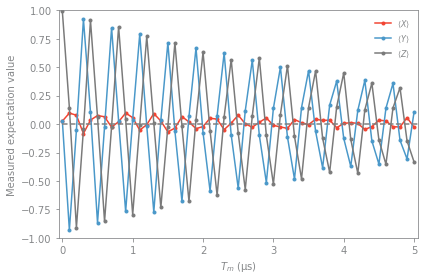

In [34]:
tsteps = len([key for key in dZ.keys() if "t_" in key])
Tm, expX, expY, expZ = plot_strong_ro_results(dX, dY, dZ, np.arange(tsteps), fit_curves=[], 
                                              artificial_detuning=0.5E6, savepath=None)
plt.plot([0,8.0], [0, 0], '--', color='gray')

# Check if the IQ voltage records have spurious rotations

Check the settings below carefully, these will be applied to filter the voltage records and re-bin them. Pay especially attentian to the `cutoff_freq`, which is the -3 dB frequency of the low-pass filter in Hz, applied to the raw demodulated voltage records. `rebin_dt` is the new voltage record `dt` of the binned voltage records, which can be changed to multiples of your `unbinned_dt`: `unbinned_dt <= rebin_dt <= strong_ro_dt`

Turning on compression of the saved h5 file can save disk space, but makes saving and accessing the data much slower (data has to be unzipped at each loading instance).

In [35]:
foldername = os.path.split(head)[-1]
new_filename = "single_prep_state_dt_20ns_meas_XYZ.h5"
save_averaged_records_only = False
cutoff_freq = 7.5e6
prep = sub
rebin_dt = 20e-9
n_levels = 2

h5_settings = {}
# h5_settings = {'compression' : "gzip", 
#                'chunks' : True}

Loop over the three different tomography axes, apply the filtering to the voltage records, rebin them and save the individual voltage records to the h5 file with filename specified above.

Note: the filtered file will be substantially smaller, since we're discarding the unbinned voltage records here.

17-39-54-2339_final_data.pickle
Correcting flipped phase for meas_+X_ge
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_50
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_49
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_48
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_47
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_46
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_45
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_44
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_43
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_42
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_41
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_X/t_40
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas

Correcting flipped phase for meas_+Z_ge
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_50
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_49
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_48
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_47
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_46
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_45
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_44
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_43
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_42
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_41
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_40
Writing to single_prep_state_dt_20ns_meas_XYZ.h5 and group prep_g/meas_Z/t_39
Writing to single_prep_s

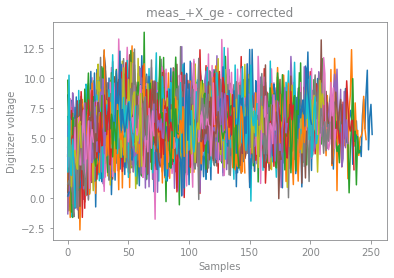

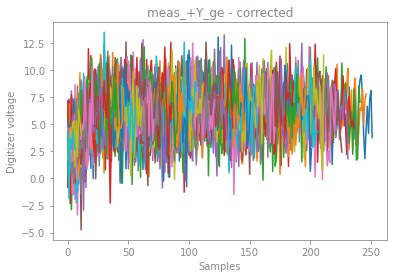

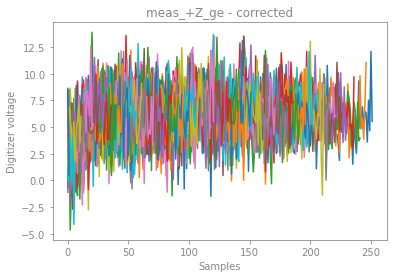

In [36]:
for flip, meas in zip([False, False, False], ["meas_+X_ge", "meas_+Y_ge", "meas_+Z_ge"]):
    old_filepath = os.path.join(head, prep, meas)
    new_filepath = head
    xyz = [m for m in ["X", "Y", "Z"] if m in meas][0]

    d = load_raw_data(old_filepath, timestep=None)
    timesteps = np.sort([int(key[2:]) for key in list(d.keys()) if key[:2] == 't_'])
    
    plt.figure()
    for jj, timestep in enumerate(timesteps[::-1]):
        unbinned_dt = d[f't_{timestep}']['unbinned_dt']
        binned_dt = d[f't_{timestep}']['binned_dt']
        
        binned_i, binned_q = rotate_iq_by_herald_angles(d, binned_unbinned='binned', n_levels=n_levels,
                                                        timestep=timestep)
        unbinned_i, unbinned_q = rotate_iq_by_herald_angles(d, binned_unbinned='unbinned', n_levels=n_levels,
                                                            timestep=timestep)
        
        if timestep == timesteps[-1]:
            # Enforce that the informational quadrature starts positive if prep = 'g'
            if prep == 'prep_g': # Z = +1, so mean(I_binned) should start off > 0.
                # Check if the first few datapoints in the voltage records are negative
                if np.mean(binned_i[:, :10]) <= 0:
                    # If so, rotate the IQ points by 180 degrees
                    print(f"Correcting flipped phase for {meas}")
                    flip_phase_for_all_timesteps = True
                else:
                    flip_phase_for_all_timesteps = False
            elif prep == 'prep_e': # Z = -1, so mean(I_binned) should start off < 0
                # Check if the first few datapoints in the voltage records are positive
                if np.mean(binned_i[:, :10]) >= 0:
                    # If so, rotate the IQ points by 180 degrees
                    print(f"Correcting flipped phase for {meas}")
                    flip_phase_for_all_timesteps = True
                else:
                    flip_phase_for_all_timesteps = False
            else: 
                flip_phase_for_all_timesteps = flip
        
        if flip_phase_for_all_timesteps: 
            for n in range(np.shape(binned_i)[0]):
                binned_i[n, :], binned_q[n, :] = rotate_points(binned_i[n, :], 
                                                               binned_q[n, :], 
                                                               np.pi)
                
                unbinned_i[n, :], unbinned_q[n, :] = rotate_points(unbinned_i[n, :], 
                                                                   unbinned_q[n, :], 
                                                                   np.pi)
                
        plt.plot(np.mean(binned_i, axis=0))
        
        # Now that all unbinned and binned trajectories are aligned, we can continue with
        # filtering and re-binning if desired.
        # Shift the time-axis since we started measuring one dt before the cts_rabi was turned on.
        n_timesteps = np.shape(d[f't_{timestep}']['binned_I'])[-1]
        binned_time_axis = np.linspace(binned_dt, n_timesteps * binned_dt, n_timesteps) - binned_dt
        
        if (jj == 0) and (binned_dt != rebin_dt): 
            print(f"Warning: binned_dt = {binned_dt}, but you're rebinning with rebin_dt = {rebin_dt}")
            
        _output = filter_and_bin_signal(unbinned_i, unbinned_q, unbinned_dt,
                                        binned_i, binned_q, rebin_dt,
                                        cutoff_freq=cutoff_freq, plot_spectrum=False, 
                                        plot_filter_output=False, savepath=None,
                                        verbose=False, keep_individual_records=True)

        unbinned_time_axis, filtered_unbinned_i, filtered_unbinned_q = _output[:3]
        rebinned_time_axis, filtered_rebinned_i, filtered_rebinned_q = _output[3:]

        if timestep == 0:
            print("Data shape for re-binned I, timestep 0 = ", np.shape(filtered_rebinned_i))
        
        with h5py.File(os.path.join(new_filepath, new_filename), 'a') as f:
            print(f"Writing to {new_filename} and group {prep}/meas_{xyz}/t_{timestep}")
            # Binned data, raw, no filtering
            if save_averaged_records_only:
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/I_binned", 
                                 data=np.mean(binned_i, axis=0), **h5_settings)
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/Q_binned", 
                                 data=np.mean(binned_q, axis=0), **h5_settings)
            else:
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/I_binned", 
                                 data=binned_i, **h5_settings)
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/Q_binned", 
                                 data=binned_q, **h5_settings)
            f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/time_axis_binned", 
                             data=binned_time_axis)
            f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/dt_binned", 
                             data=binned_dt)

            # Binned data, filtered, re-binned to same bin size as raw binned data
            if save_averaged_records_only:
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/I_binned_filtered", 
                                 data=np.mean(filtered_rebinned_i, axis=0), **h5_settings)
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/Q_binned_filtered", 
                                 data=np.mean(filtered_rebinned_q, axis=0), **h5_settings)
            else:
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/I_binned_filtered", 
                                 data=filtered_rebinned_i, **h5_settings)
                f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/Q_binned_filtered", 
                                 data=filtered_rebinned_q, **h5_settings)
            f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/time_axis_filtered", 
                             data=rebinned_time_axis)
            f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/dt_filtered", 
                             data=rebin_dt)

            # Unbinned data, raw, no filtering (averaged trajectories only)
    #         if save_averaged_records_only:
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/I_unbinned", data=np.mean(unbinned_i, axis=0))
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/Q_unbinned", data=np.mean(unbinned_q, axis=0))
    #         else:
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/I_unbinned", data=unbinned_i)
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/Q_unbinned", data=unbinned_q)

            # Unbinned data, filtered (averaged trajectories only)
    #         if save_averaged_records_only:
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/I_unbinned_filtered", data=np.mean(filtered_unbinned_i, axis=0))
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/Q_unbinned_filtered", data=np.mean(filtered_unbinned_q, axis=0))
    #         else:
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/I_unbinned_filtered", data=filtered_unbinned_i)
    #             f.create_dataset(f"meas_{xyz}/t_{timestep}/Q_unbinned_filtered", data=filtered_unbinned_q)
    #         f.create_dataset(f"meas_{xyz}/t_{timestep}/time_axis_unbinned", data=unbinned_time_axis)
    #         f.create_dataset(f"meas_{xyz}/t_{timestep}/dt_unbinned", data=unbinned_dt)

            # Additional settings
            f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/final_ro_results", 
                             data=d[f't_{timestep}']['final_ro_results'].astype(np.int), 
                             **h5_settings)
            f.create_dataset(f"{prep}/meas_{xyz}/t_{timestep}/cutoff_freq", 
                             data=cutoff_freq)
    
    plt.title(meas+ " - corrected")
    plt.ylabel("Digitizer voltage")
    plt.xlabel("Samples")